In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Metrics

In [48]:
from testing_module import test_metric
def my_confusion_matrix(y_true, y_pred):
    y_true = y_true.values if isinstance(y_true, pd.Series) else y_true
    y_pred = y_pred.values if isinstance(y_pred, pd.Series) else y_pred
    n_classes = int(max(y_true.max(), y_pred.max())) + 1
    cm = np.zeros((n_classes, n_classes), dtype=int)
    for idx in range(len(y_true)):
        y_idx = int(y_true[idx])
        x_idx = int(y_pred[idx])
        cm[y_idx][x_idx] += 1
    return cm

def my_accuracy_function(y_true, y_pred):
    return sum(y_true == y_pred) / len(y_true)

def my_recall_function(y_true, y_pred):
    cm = my_confusion_matrix(y_true, y_pred)
    n_classes = cm.shape[0]
    if n_classes > 2:
        recall = sum([cm[idx][idx]/sum(cm[idx]) if sum(cm[idx]) != 0 else 0 for idx in range(n_classes)])
        return recall / n_classes
    val = cm[1][1]/(cm[1][1]+cm[1][0])
    return val if not np.isnan(val) else 0.0

def my_precision_function(y_true, y_pred):
    cm = my_confusion_matrix(y_true, y_pred)
    n_classes = cm.shape[0]
    if n_classes > 2:
        precision = sum([cm[idx][idx]/sum(cm[:, idx]) if sum(cm[:, idx]) != 0 else 0 for idx in range(n_classes)])
        return precision / n_classes
    val = cm[1][1]/(cm[1][1]+cm[0][1])
    return val if not np.isnan(val) else 0.0

def my_f1_function(y_true, y_pred):
    cm = my_confusion_matrix(y_true, y_pred)
    n_classes = cm.shape[0]
    if n_classes > 2:
        f1 = 0
        for idx in range(n_classes):
            precision = cm[idx][idx]/sum(cm[:, idx]) if sum(cm[:, idx]) != 0 else 0
            recall = cm[idx][idx]/sum(cm[idx]) if sum(cm[idx]) != 0 else 0
            div = precision + recall
            f1 += 2*(precision*recall)/div if div != 0 else 0
        return f1/n_classes        
    precision = my_precision_function(y_true, y_pred)
    recall = my_recall_function(y_true, y_pred)
    div = precision + recall
    return 2 * (precision * recall) / div if div != 0 else 0
    

# Tests

In [49]:
test_metric(confusion_matrix, my_confusion_matrix)
test_metric(accuracy_score, my_accuracy_function)
test_metric(recall_score, my_recall_function)
test_metric(precision_score, my_precision_function)
test_metric(f1_score, my_f1_function)

(None, None)

# Classification task

In [50]:
import pandas as pd
import os
data = pd.read_csv(os.path.join(os.getcwd(), 'data', 'seeds_dataset.csv'))

# Train & compare function

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
def compare_models(model1, model2, dataset, target='class'):
    # Pretty the same as in the lecture notebook
    fts = [col for col in dataset.columns if col != target]
    def calculate_metrics(model, dataset, model_name, dataset_name):
        # util func returning a DF with metrics wrt model, dataset
        y_pred = model.predict(dataset.loc[:, fts])
        y_true = dataset.loc[:, target]
        scores = [my_accuracy_function(y_true, y_pred), my_precision_function(y_true, y_pred), \
            my_recall_function(y_true, y_pred), my_f1_function(y_true, y_pred)]
        return pd.DataFrame({'model': [model_name]*4, 'dataset': [dataset_name]*4,\
            'metric': ['accuracy', 'precision', 'recall', 'f1'], 'value': scores})
    
    X_train, X_test, y_train, y_test = train_test_split(dataset.loc[:, fts], dataset.loc[:, target], test_size=0.25)
    model1.fit(X_train, y_train)
    model2.fit(X_train, y_train)
    train_dataset = pd.concat((X_train, y_train), axis=1)
    test_dataset = pd.concat((X_test, y_test), axis=1)
    metrics = pd.DataFrame(columns=['model', 'dataset', 'metric', 'value'])
    _, axs = plt.subplots(2, 2, figsize=(10, 10))
    for y_idx, m in enumerate(((model1, 'model1'), (model2, 'model2'))):
        model, model_name = m
        for x_idx, d in enumerate(((train_dataset, 'train'), (test_dataset, 'test'))):
            ds, ds_name = d
            new_metrics = calculate_metrics(model, ds, model_name, ds_name)
            metrics = pd.concat((metrics, new_metrics), axis=0)
            y_pred = model.predict(ds.loc[:, fts])
            y_true = ds.loc[:, target]
            sns.heatmap(my_confusion_matrix(y_true, y_pred), annot=True, fmt='d', ax=axs[y_idx][x_idx])
    
    _, axs = plt.subplots(1, 2, figsize=(10, 5))
    for idx, model_name in enumerate(('model1', 'model2')):
        metrics.loc[metrics.model==model_name].groupby(['dataset', 'metric']).value.agg(lambda x: x)\
            .unstack(level=0).plot(kind='bar', subplots=False, title=model_name, ax=axs[idx])
    _, axs = plt.subplots(1, 2, figsize=(10, 5))
    for idx, ds_name in enumerate(('train', 'test')):
        metrics.loc[metrics.dataset==ds_name].groupby(['model', 'metric']).value.agg(lambda x: x)\
            .unstack(level=0).plot(kind='bar', subplots=False, title=ds_name, ax=axs[idx])
    plt.show()

# Usage example

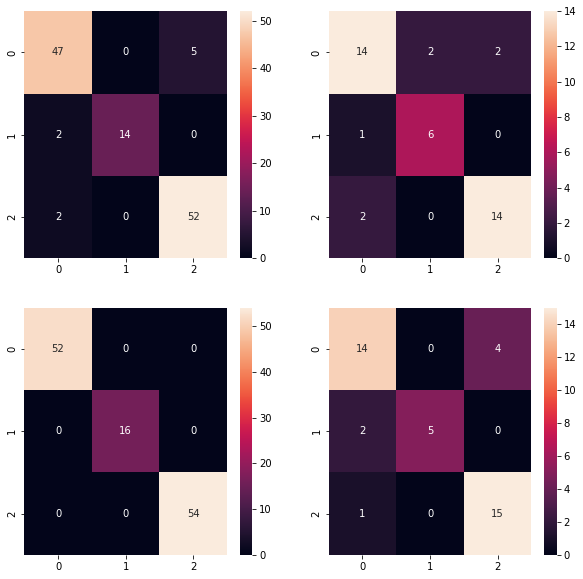

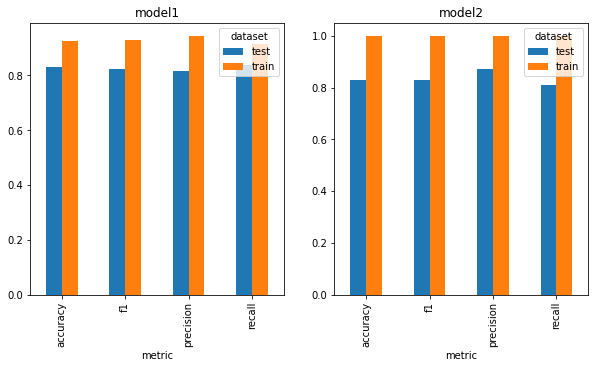

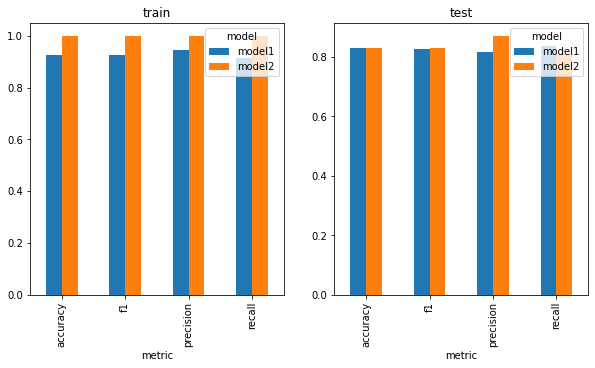

In [65]:
lmodel = LogisticRegression(max_iter=1000)
tmodel = DecisionTreeClassifier()
compare_models(lmodel, tmodel, data, target='class')